In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names

In [3]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [4]:
print("Dataset information:")
print(f"Shape: {df.shape}")
print("\nFeature names:")
print(feature_names)
print("\nDescriptive statistics:")
print(df.describe().round(2))

Dataset information:
Shape: (442, 11)

Feature names:
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Descriptive statistics:
          age     sex     bmi      bp  ...      s4      s5      s6  target
count  442.00  442.00  442.00  442.00  ...  442.00  442.00  442.00  442.00
mean    -0.00    0.00   -0.00   -0.00  ...   -0.00    0.00    0.00  152.13
std      0.05    0.05    0.05    0.05  ...    0.05    0.05    0.05   77.09
min     -0.11   -0.04   -0.09   -0.11  ...   -0.08   -0.13   -0.14   25.00
25%     -0.04   -0.04   -0.03   -0.04  ...   -0.04   -0.03   -0.03   87.00
50%      0.01   -0.04   -0.01   -0.01  ...   -0.00   -0.00   -0.00  140.50
75%      0.04    0.05    0.03    0.04  ...    0.03    0.03    0.03  211.50
max      0.11    0.05    0.17    0.13  ...    0.19    0.13    0.14  346.00

[8 rows x 11 columns]


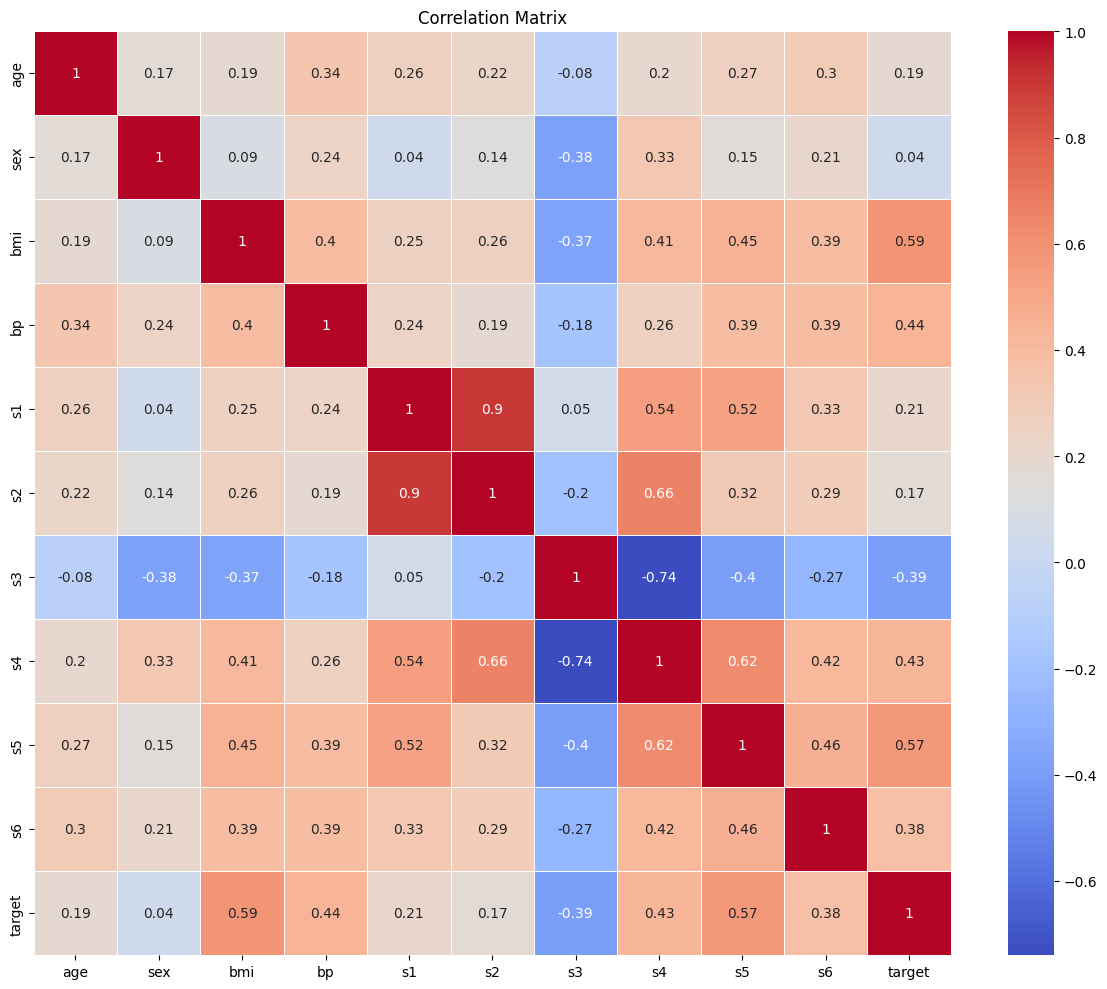

In [5]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr().round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Function to evaluate models
def evaluate_regression_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [10]:
# Create a dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}


--- Models with all features ---
Linear Regression - MSE: 2900.19, R²: 0.4526
Ridge Regression - MSE: 2892.01, R²: 0.4541
Random Forest - MSE: 2959.18, R²: 0.4415
Gradient Boosting - MSE: 2898.20, R²: 0.4530

--- RFE with different numbers of features ---


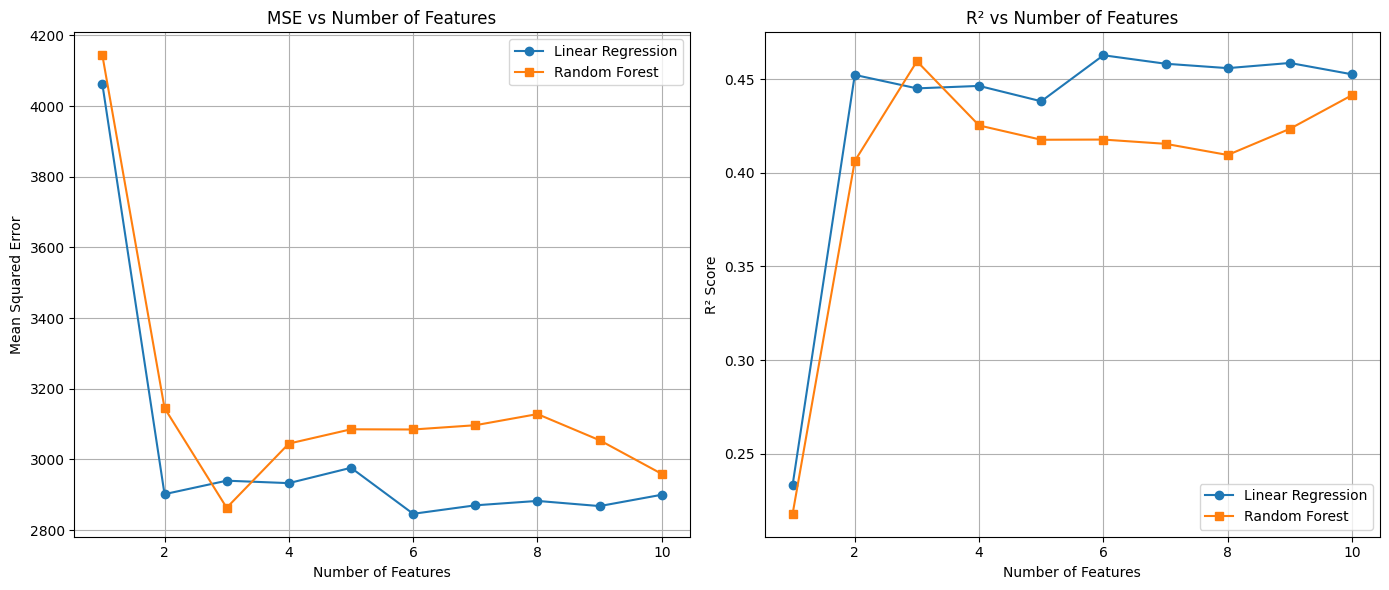

In [12]:
# Compare models with all features
print("\n--- Models with all features ---")
baseline_results = {}

for name, model in models.items():
    mse, r2 = evaluate_regression_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    baseline_results[name] = (mse, r2)
    print(f"{name} - MSE: {mse:.2f}, R²: {r2:.4f}")

# RFE with different numbers of features
print("\n--- RFE with different numbers of features ---")
n_features_range = range(1, len(feature_names) + 1)
linear_results = []
rf_results = []

for n_features in n_features_range:
    # Linear Regression with RFE
    linear_rfe = RFE(LinearRegression(), n_features_to_select=n_features)
    linear_rfe.fit(X_train_scaled, y_train)
    X_train_linear_rfe = linear_rfe.transform(X_train_scaled)
    X_test_linear_rfe = linear_rfe.transform(X_test_scaled)
    linear_model = LinearRegression()
    mse, r2 = evaluate_regression_model(linear_model, X_train_linear_rfe, X_test_linear_rfe, y_train, y_test)
    linear_results.append((n_features, mse, r2))
    
    # Random Forest with RFE
    rf_rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=n_features)
    rf_rfe.fit(X_train_scaled, y_train)
    X_train_rf_rfe = rf_rfe.transform(X_train_scaled)
    X_test_rf_rfe = rf_rfe.transform(X_test_scaled)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mse, r2 = evaluate_regression_model(rf_model, X_train_rf_rfe, X_test_rf_rfe, y_train, y_test)
    rf_results.append((n_features, mse, r2))

# Plot results
linear_results = np.array(linear_results)
rf_results = np.array(rf_results)

plt.figure(figsize=(14, 6))

# MSE plot
plt.subplot(1, 2, 1)
plt.plot(linear_results[:, 0], linear_results[:, 1], 'o-', label='Linear Regression')
plt.plot(rf_results[:, 0], rf_results[:, 1], 's-', label='Random Forest')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Number of Features')
plt.grid(True)
plt.legend()

# R² plot
plt.subplot(1, 2, 2)
plt.plot(linear_results[:, 0], linear_results[:, 2], 'o-', label='Linear Regression')
plt.plot(rf_results[:, 0], rf_results[:, 2], 's-', label='Random Forest')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('R² vs Number of Features')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Determine optimal number of features for both models
linear_optimal_idx = np.argmax(linear_results[:, 2])
rf_optimal_idx = np.argmax(rf_results[:, 2])

linear_optimal = int(linear_results[linear_optimal_idx, 0])
rf_optimal = int(rf_results[rf_optimal_idx, 0])

print(f"\nOptimal number of features for Linear Regression: {linear_optimal}")
print(f"Optimal number of features for Random Forest: {rf_optimal}")


Optimal number of features for Linear Regression: 6
Optimal number of features for Random Forest: 3


In [14]:
# Run RFECV for automatic feature selection
print("\n--- Running RFECV ---")
rfecv = RFECV(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    step=1,
    cv=KFold(5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    min_features_to_select=1
)

rfecv.fit(X_train_scaled, y_train)
optimal_features_count = rfecv.n_features_
print(f"Optimal number of features determined by RFECV: {optimal_features_count}")


--- Running RFECV ---
Optimal number of features determined by RFECV: 9


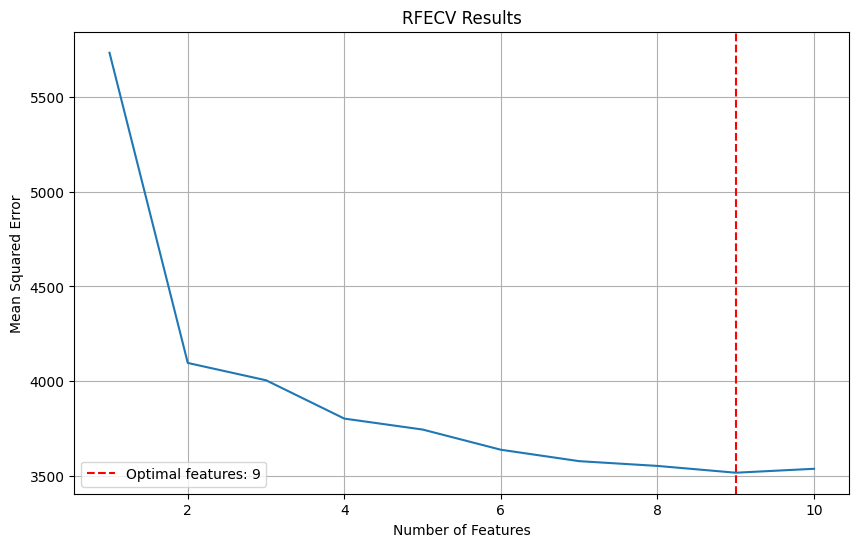

In [15]:
# Plot RFECV results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         -rfecv.cv_results_['mean_test_score'])  # Negate because we're using neg_mean_squared_error
plt.axvline(x=optimal_features_count, color='r', linestyle='--', 
            label=f'Optimal features: {optimal_features_count}')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('RFECV Results')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Get selected features from RFECV
selected_features = [feature_names[i] for i, selected in enumerate(rfecv.support_) if selected]
print("\nSelected features by RFECV:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")


Selected features by RFECV:
1. age
2. bmi
3. bp
4. s1
5. s2
6. s3
7. s4
8. s5
9. s6


In [17]:
# Feature ranking
feature_ranking = pd.Series(rfecv.ranking_, index=feature_names).sort_values()
print("\nFeature ranking (lower is better):")
print(feature_ranking)


Feature ranking (lower is better):
age    1
bmi    1
bp     1
s1     1
s2     1
s3     1
s4     1
s5     1
s6     1
sex    2
dtype: int64


In [18]:
# Train final model with optimal features
X_train_rfecv = rfecv.transform(X_train_scaled)
X_test_rfecv = rfecv.transform(X_test_scaled)

final_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

print("\n--- Final models with optimal features ---")
final_results = {}

for name, model in final_models.items():
    mse, r2 = evaluate_regression_model(model, X_train_rfecv, X_test_rfecv, y_train, y_test)
    final_results[name] = (mse, r2)
    print(f"{name} - MSE: {mse:.2f}, R²: {r2:.4f}")


--- Final models with optimal features ---
Linear Regression - MSE: 2986.73, R²: 0.4363
Ridge Regression - MSE: 2976.60, R²: 0.4382
Random Forest - MSE: 3054.39, R²: 0.4235
Gradient Boosting - MSE: 2953.69, R²: 0.4425


In [20]:
# Compare baseline vs optimized models
comparison_data = []
for name in models.keys():
    baseline_mse, baseline_r2 = baseline_results[name]
    optimized_mse, optimized_r2 = final_results[name]
    mse_improvement = ((baseline_mse - optimized_mse) / baseline_mse) * 100
    r2_improvement = ((optimized_r2 - baseline_r2) / abs(baseline_r2)) * 100
    comparison_data.append([name, baseline_mse, optimized_mse, mse_improvement, 
                           baseline_r2, optimized_r2, r2_improvement])

comparison_df = pd.DataFrame(comparison_data, 
                            columns=['Model', 'Baseline MSE', 'Optimized MSE', 'MSE Improvement (%)',
                                    'Baseline R²', 'Optimized R²', 'R² Improvement (%)'])

print("\nModel Comparison:")
comparison_df.round(2)


Model Comparison:


,Model,Baseline MSE,Optimized MSE,MSE Improvement (%),Baseline R²,Optimized R²,R² Improvement (%)
0,Linear Regression,2900.19,2986.73,-2.98,0.45,0.44,-3.61
1,Ridge Regression,2892.01,2976.60,-2.92,0.45,0.44,-3.52
2,Random Forest,2959.18,3054.39,-3.22,0.44,0.42,-4.07
3,Gradient Boosting,2898.20,2953.69,-1.91,0.45,0.44,-2.31


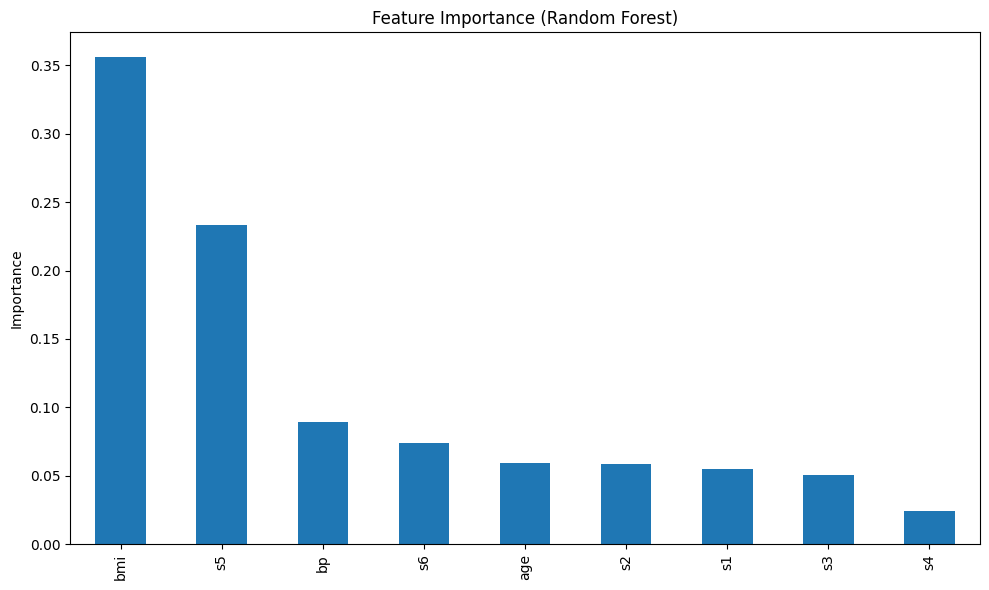

In [21]:
# Feature importance from the best model
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train_rfecv, y_train)

try:
    feature_importance = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance (Random Forest)')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
except:
    print("Could not calculate feature importance for the selected model.")